# Exploratory Data Analysis (Formatted Zone)
Complex Seasonality Analysis

In [2]:
import datetime

from database_settings import postgres_utilities
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from exploratory_data_analysis.formatted import utilities

## Get the time series


In [3]:
# Establish the connection with the Persistent Zone
engine = postgres_utilities.engine()
# Filters
net_weight_threshold = 100
value_usd_threshold = 200
headings_count_threshold = 100
year_threshold = 2017
# Get all the data filtered
df = pd.DataFrame(postgres_utilities.run_query_file(engine,
                                           './queries/heading_data.sql',
                                           params={'year_threshold': year_threshold,
                                                   'headings_count_threshold': headings_count_threshold,
                                                   'value_usd_threshold': value_usd_threshold,
                                                   'net_weight_threshold': net_weight_threshold}))

Connected to Formatted Zone successfully!


In [4]:
# Select a random heading (optionally, select a exporter)
heading, description, exporter = df.sample()[['heading','description', 'exporter_id']].iloc[0]
print('Heading: {}, Description: {}'.format(heading,description))
heading_data = df[(df['heading']==heading)].copy()

Heading: 0806100000, Description: Uvas frescas


In [5]:
# Generate the time granularities
start_date = heading_data['boarding_date'].min()
end_date = heading_data['boarding_date'].max()

time_granularities = utilities.generate_time_granularities(start_date,end_date)

### Daily kilogram's price time series

In [6]:
# usd/kg time series
heading_data['usd_kg'] = heading_data['value_usd']/heading_data['net_weight']
heading_data['usd_kg'] = heading_data['usd_kg'].astype(float)
heading_data['usd_kg'] = heading_data['usd_kg'].round(3)
# Group by boarding_date
usd_kg = heading_data[['boarding_date','usd_kg']].groupby(by=['boarding_date']).mean().round(3)
# Impute missing dates assigning the usd_kg of the day before
usd_kg.index = pd.to_datetime(usd_kg.index)
usd_kg = usd_kg.resample('D').ffill()
# Add the time granularities
usd_kg = pd.concat([usd_kg, time_granularities], axis=1)
usd_kg

,usd_kg,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-01-02,1.878,2017,1,1,1,1,1,1,2,2,2,2,1,2,2,2,2
2017-01-03,2.216,2017,1,1,1,1,1,1,3,3,3,3,2,2,2,2,2
2017-01-04,2.691,2017,1,1,1,1,1,1,4,4,4,4,3,2,2,2,2
2017-01-05,2.086,2017,1,1,1,1,1,1,5,5,5,5,4,2,2,2,2
2017-01-06,2.501,2017,1,1,1,1,1,1,6,6,6,6,5,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-15,0.896,2023,1,2,4,4,1,2,105,105,15,15,6,16,16,3,3
2023-04-16,0.896,2023,1,2,4,4,1,2,106,106,16,16,7,16,16,3,3
2023-04-17,0.896,2023,1,2,4,4,1,2,107,107,17,17,1,17,17,4,4
2023-04-18,0.896,2023,1,2,4,4,1,2,108,108,18,18,2,17,17,4,4


### Daily total (net) weight exporter time series

In [7]:
# total net weight time series
# Group by boarding_date
net_weight = heading_data[['boarding_date','net_weight']].groupby(by=['boarding_date']).sum().round(3)
# Impute missing dates assigning 0 kg for days without shipments
net_weight.index = pd.to_datetime(net_weight.index)
net_weight = net_weight.resample('D').asfreq()
net_weight.fillna(0.0, inplace=True)
# Convert numerical columns to float
net_weight = net_weight.astype({'net_weight': 'float'})
# Add the time granularities
net_weight = pd.concat([net_weight, time_granularities], axis=1)

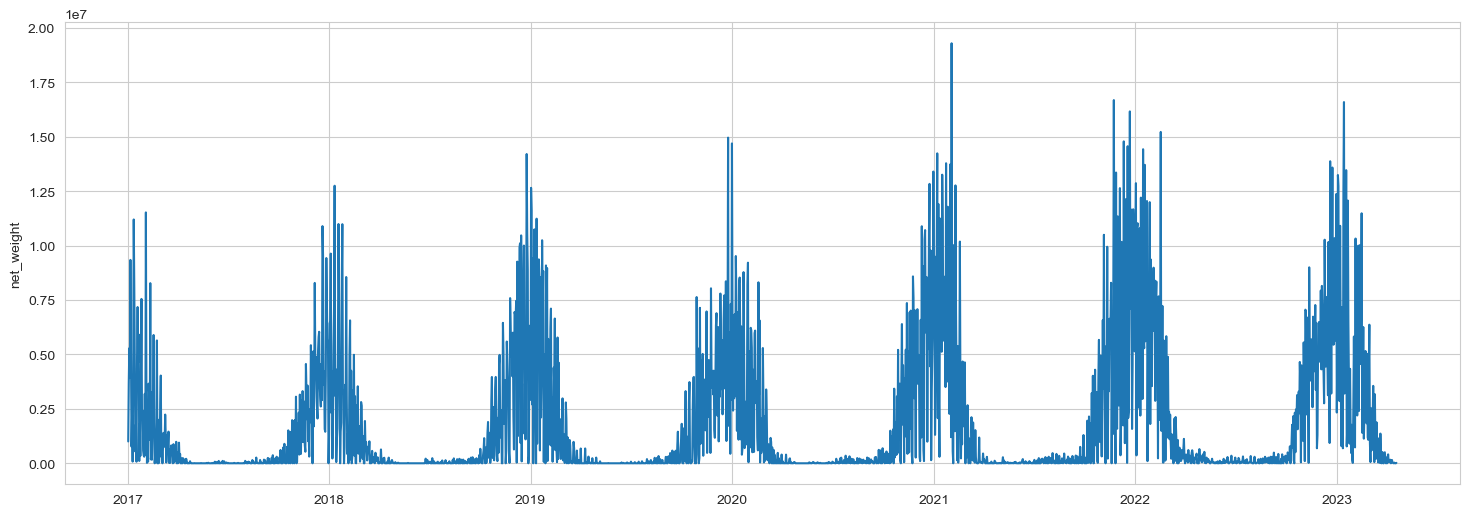

In [8]:
# Plot time series
plt.figure(figsize=(18,6))
sns.lineplot(x=net_weight.index, y="net_weight", data=net_weight)
plt.show()

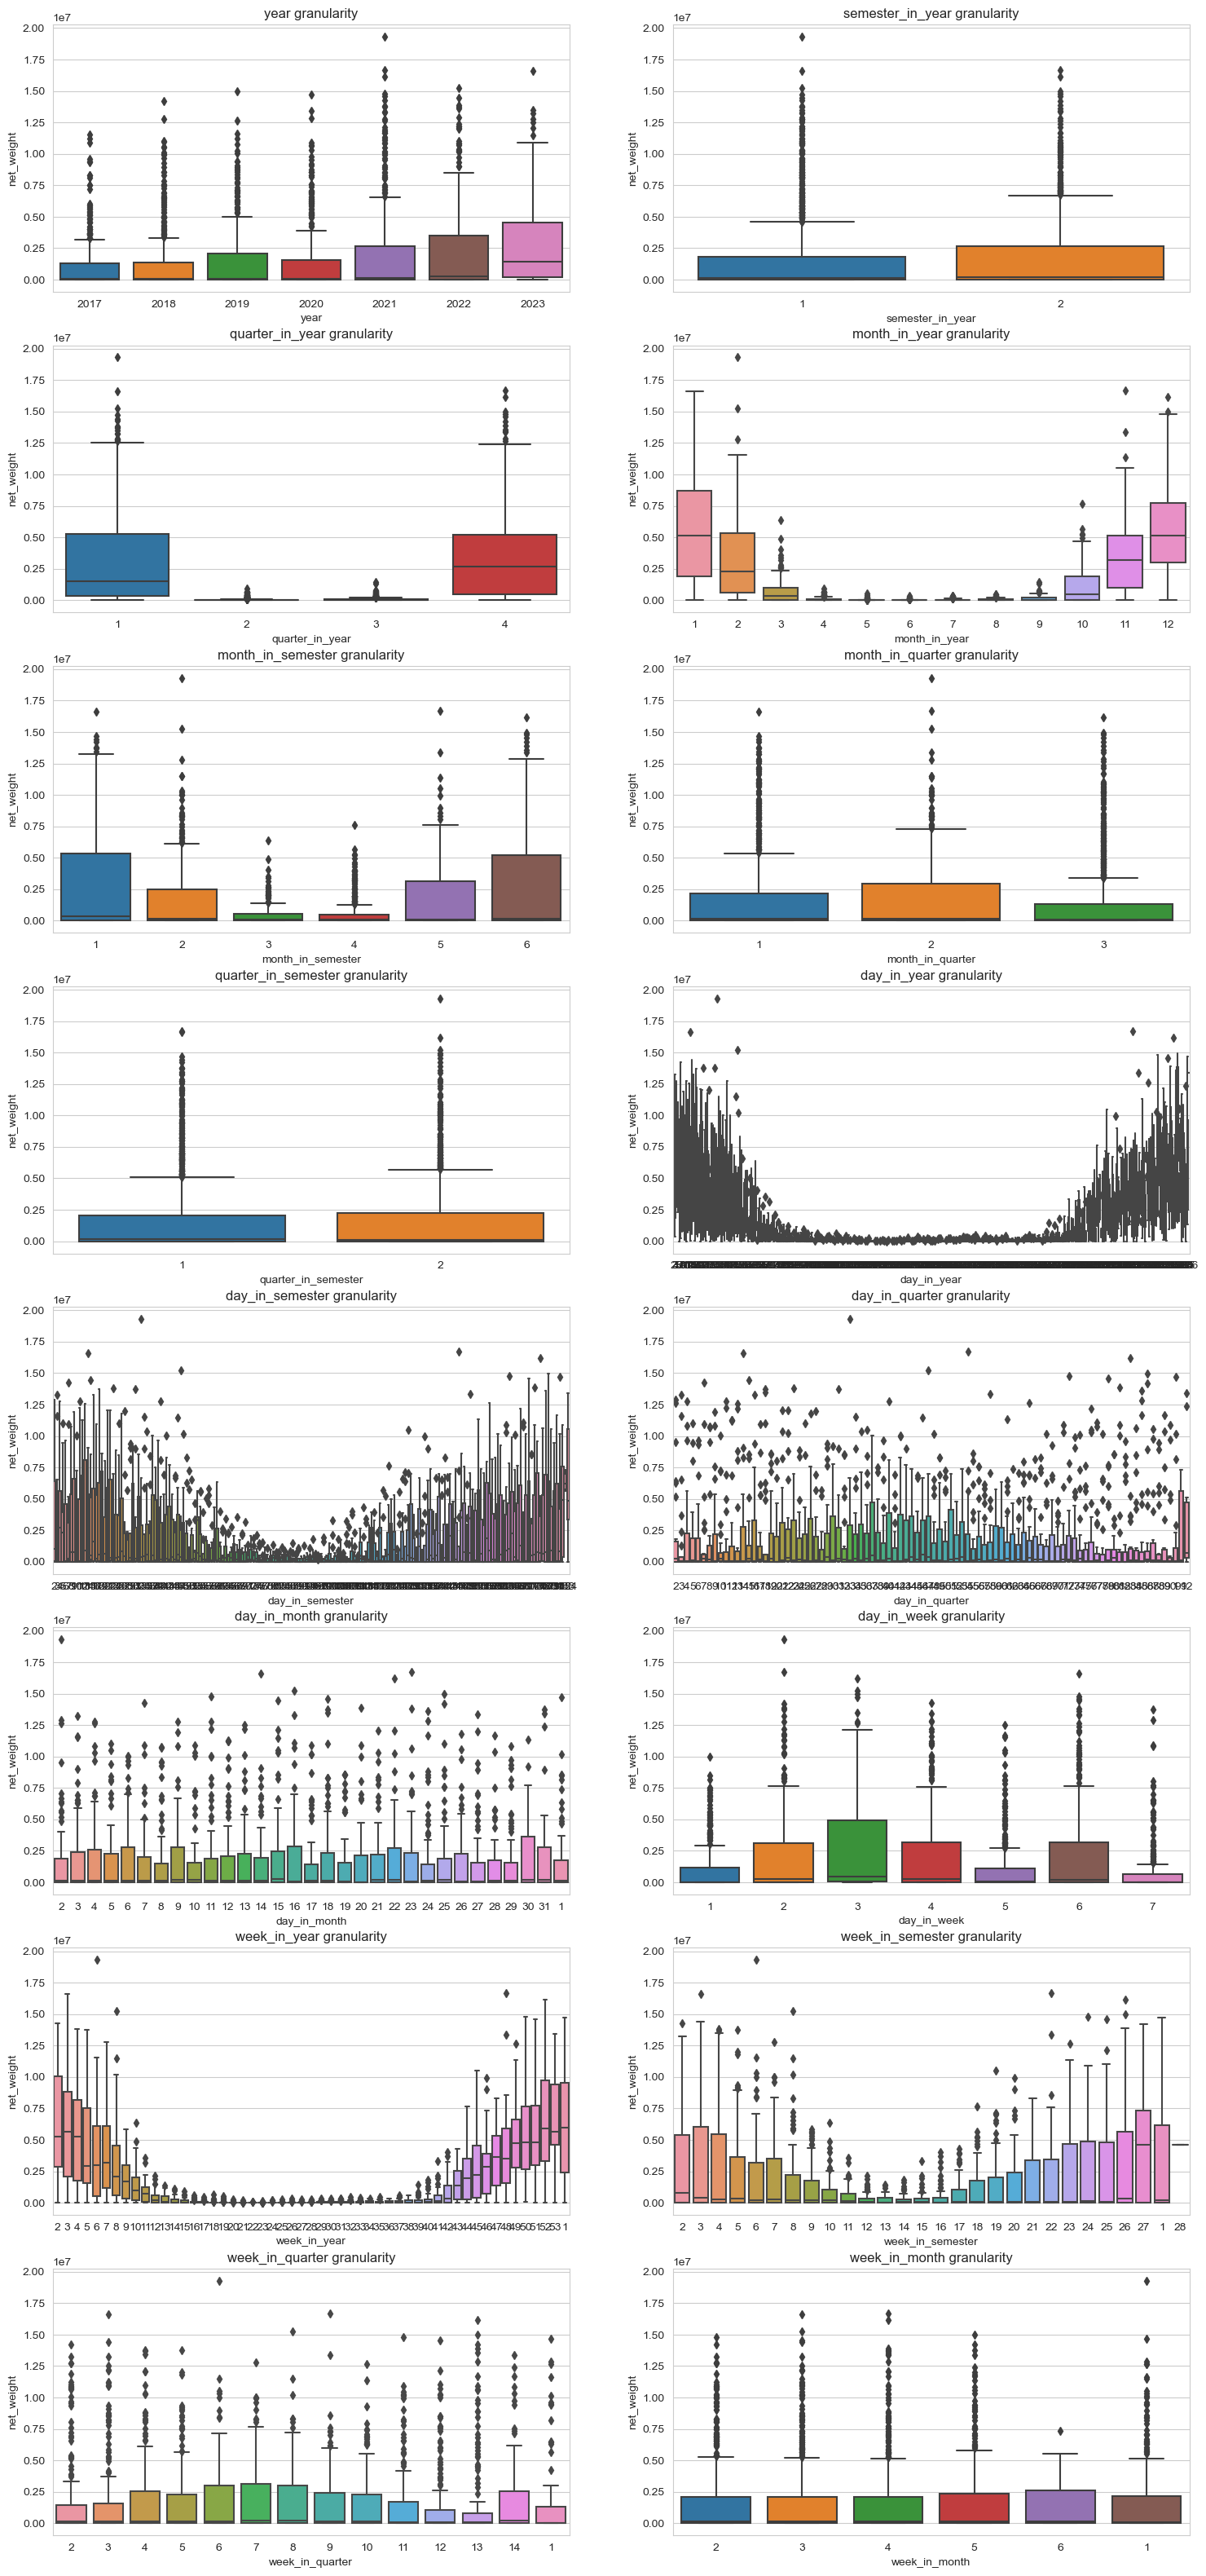

In [26]:
# Granularity plots

data = net_weight
target_column = 'net_weight'
columns = data.columns.tolist()
columns.remove(target_column)
num_columns = len(columns)
num_rows = (num_columns + 1) // 2

# Create the subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(18, num_rows*5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each column and create the corresponding subplot
for i, column in enumerate(columns):
    sns.boxplot(ax=axes[i], data=data, x=column, y=target_column)
    axes[i].set_title(f"{column} granularity")

# If the number of columns is odd, remove the last empty subplot
if num_columns % 2 != 0:
    fig.delaxes(axes[num_columns])

# Add a main title to the entire plot
# fig.suptitle('Granularity plots')

# Display the plot
plt.show()

<Axes: xlabel='month_in_quarter', ylabel='net_weight'>

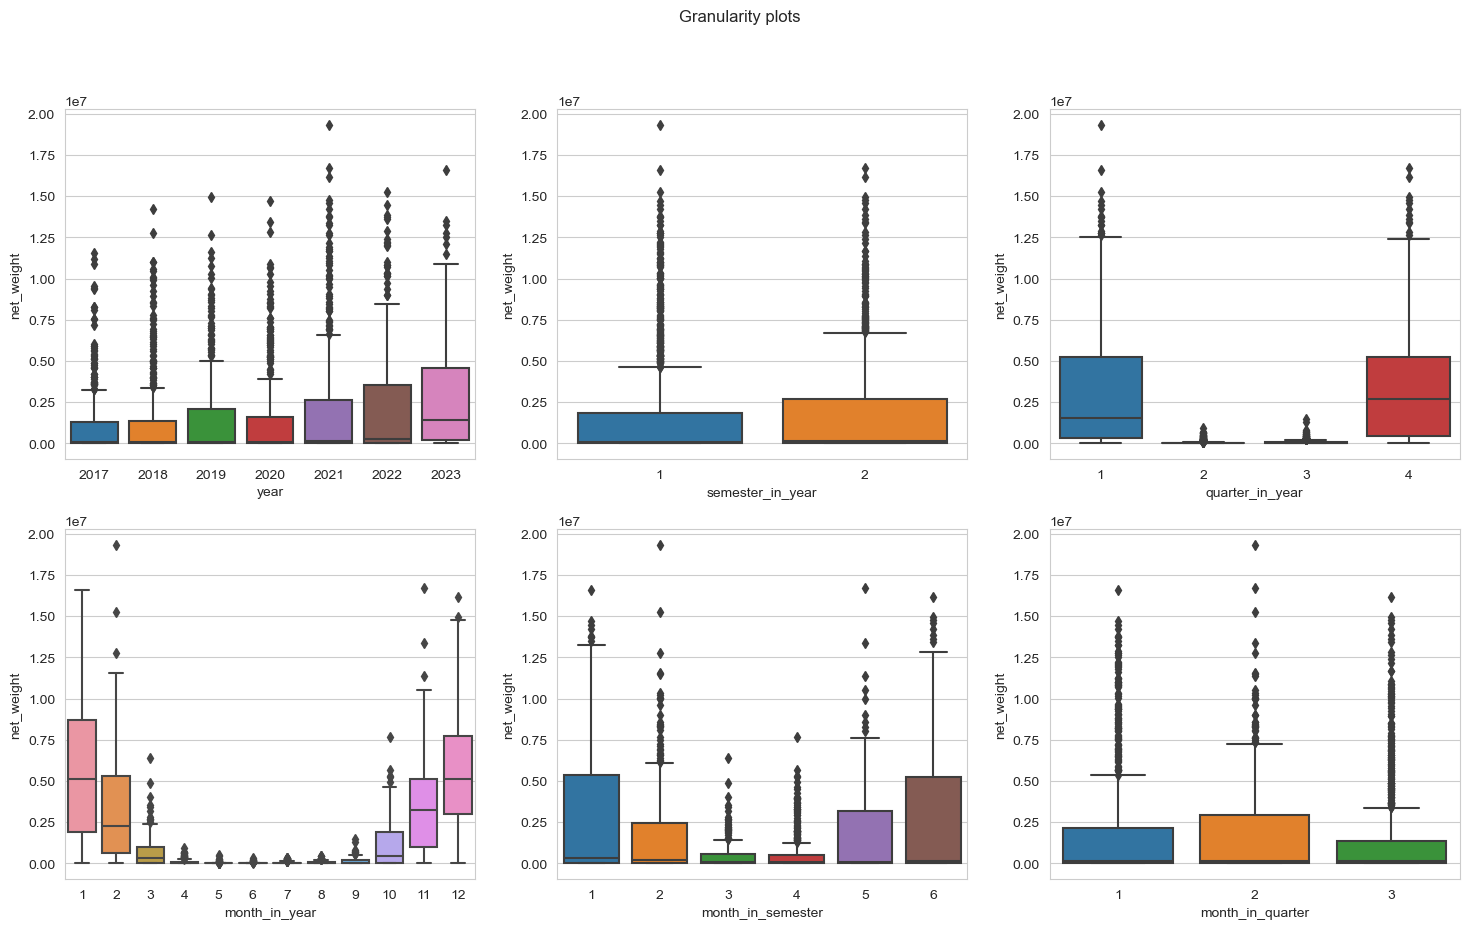

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Granularity plots')
data = net_weight
sns.boxplot(ax=axes[0, 0], data=data, x='year', y='net_weight')
sns.boxplot(ax=axes[0, 1], data=data, x='semester_in_year', y='net_weight')
sns.boxplot(ax=axes[0, 2], data=data, x='quarter_in_year', y='net_weight')
sns.boxplot(ax=axes[1, 0], data=data, x='month_in_year', y='net_weight')
sns.boxplot(ax=axes[1, 1], data=data, x='month_in_semester', y='net_weight')
sns.boxplot(ax=axes[1, 2], data=data, x='month_in_quarter', y='net_weight')

In [ ]:
# Seasonal plot (yearly)
plt.figure(figsize=(18,6))
sns.scatterplot(x='quarter_in_year',
            y='net_weight',
            data = net_weight,
            #legend='full',
            #palette=sns.color_palette("dark:salmon_r", as_cmap=True),
            )
#plt.legend(bbox_to_anchor=(1, 1), loc=2);
plt.show()

In [ ]:
sns.boxplot(x=pd.to_datetime(net_weight['boarding_date']).dt.day,
            y=net_weight['net_weight'],
            hue=pd.to_datetime(net_weight['boarding_date']).dt.month)
plt.show()